In [10]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import optimizers, metrics, losses, metrics, layers, Sequential, activations
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype(np.float32) / 255. 

In [4]:
train_images_with_noise_channels = np.concatenate([train_images, np.random.random((len(train_images), 784))], axis=1)
train_images_with_zero_channels = np.concatenate([train_images, np.zeros((len(train_images), 784))], axis=1)

In [8]:
def get_model():
    model = Sequential([
        layers.Dense(512, activation=activations.relu),
        layers.Dense(10, activation=activations.softmax)
    ])
    model.compile(optimizer=optimizers.RMSprop(),
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics=metrics.SparseCategoricalAccuracy())
    return model

In [9]:
model = get_model()
history_noise = model.fit(train_images_with_noise_channels,
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2,
                          verbose=0)

model = get_model()
history_zeros = model.fit(train_images_with_zero_channels,
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2,
                          verbose=0)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-07-19 07:53:14.614766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-19 07:53:14.614930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-19 07:53:14.859963: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-19 07:53:15.258829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-19 07:53:18.895026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-19 07:53:41.365440: I tensorflow/core/grappler/o

In [11]:
history_noise.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

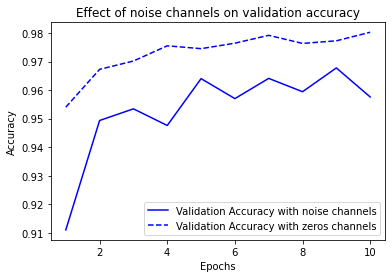

In [14]:
plt.plot(range(1, 11), history_noise.history['val_sparse_categorical_accuracy'], 'b-', label='Validation Accuracy with noise channels')
plt.plot(range(1, 11), history_zeros.history['val_sparse_categorical_accuracy'], 'b--', label='Validation Accuracy with zeros channels')
plt.title('Effect of noise channels on validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Noisy Channels leads to overfitting despite the same information contained in the samples. Thus we need to perform **Feature Selection**.

In other words, we need some metric to filter out features that do not meaningfully contribute to training.

**The Manifold Hypothesis**

We understand that models will fit random noisy data even if it does not represent anything, as long as there is enough representational parameters. Then how does Deep Learning work? Shouldn't they just learn an ad-hoc mapping between training data and targets, like a fancy dict? The reason why generalization works lies in the nature of information in the real world.

The manifold hypothesis posits that all natural data lies on a low-dimensional manifold within the higher-dimensional subspace where it is encoded. Eg. a 2D curve is composed of 1D lines, so it is a 1D manifold within a 2D space. The reason why deep learning works is that according to this hypothesis, natural data lies on a much lower dimension than the higher dimensional space it is represented in, which is why the model needs to learn in a very specific subspace within a very high number of possible values in that space.

Within one of these manifolds, it is also possible to interpolate between two inputs, i.e. morph one into another via a continuous path along which all points fall on the manifold.

## Regularization Techniques

Smaller Model

In [16]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results 

train_data = vectorize_sequences(train_data)

model = Sequential([
    layers.Dense(16, activation=activations.relu),
    layers.Dense(16, activation=activations.relu),
    layers.Dense(1, activation=activations.sigmoid)
])

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy()])

history_original = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4, verbose=0)

2023-07-21 13:02:56.736762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-21 13:02:57.584128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [17]:
model = Sequential([
    layers.Dense(4, activation=activations.relu),
    layers.Dense(4, activation=activations.relu),
    layers.Dense(1, activation=activations.sigmoid)
])

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy()])

history_smaller_model = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4, verbose=0)

2023-07-21 13:04:03.471179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-21 13:04:04.625389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [27]:
model = Sequential([
    layers.Dense(128, activation=activations.relu),
    layers.Dense(128, activation=activations.relu),
    layers.Dense(1, activation=activations.sigmoid)
])

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy()])

history_larger_model = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4, verbose=0)

2023-07-21 14:27:15.129120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-21 14:27:16.202041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


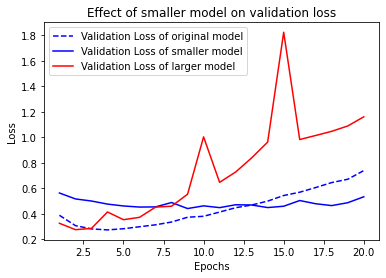

In [29]:
plt.plot(range(1, 21), history_original.history['val_loss'], 'b--', label='Validation Loss of original model')
plt.plot(range(1, 21), history_smaller_model.history['val_loss'], 'b-', label='Validation Loss of smaller model')
plt.plot(range(1, 21), history_larger_model.history['val_loss'], 'r-', label='Validation Loss of larger model')
plt.title('Effect of smaller model on validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Adding Weight Regularization

Weight Regularization (L1, L2, L1 + L2) works best with smaller models. Larger models are too overparameterized for weight regularization to have any real impact.

In [30]:
from tensorflow.keras import regularizers

In [34]:
model = Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation=activations.relu),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation=activations.relu),
    layers.Dense(1, activation=activations.sigmoid)])

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy()])

history_l2_reg = model.fit(train_data,
                           train_labels,
                           epochs=20,
                           batch_size=512,
                           validation_split=0.4,
                           verbose=0)

model = Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l1(0.002),
                 activation=activations.relu),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l1(0.002),
                 activation=activations.relu),
    layers.Dense(1, activation=activations.sigmoid)])

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy()])

history_l1_reg = model.fit(train_data,
                           train_labels,
                           epochs=20,
                           batch_size=512,
                           validation_split=0.4,
                           verbose=0)

model = Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                 activation=activations.relu),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                 activation=activations.relu),
    layers.Dense(1, activation=activations.sigmoid)])

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy()])

history_l1_l2_reg = model.fit(train_data,
                           train_labels,
                           epochs=20,
                           batch_size=512,
                           validation_split=0.4,
                           verbose=0)

2023-07-24 09:41:04.009598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-24 09:41:05.186133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-24 09:41:14.502176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-24 09:41:15.773756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-24 09:41:24.901340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-24 09:41:26.203791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


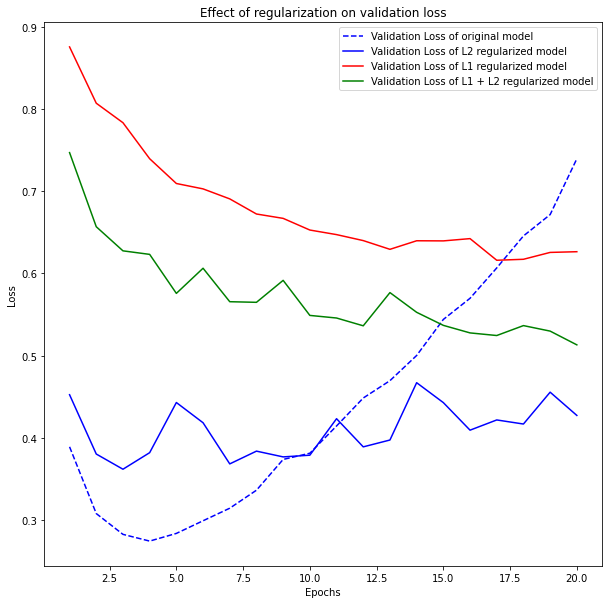

In [36]:
plt.figure(figsize=(10,10))
plt.plot(range(1, 21), history_original.history['val_loss'], 'b--', label='Validation Loss of original model')
plt.plot(range(1, 21), history_l2_reg.history['val_loss'], 'b-', label='Validation Loss of L2 regularized model')
plt.plot(range(1, 21), history_l1_reg.history['val_loss'], 'r-', label='Validation Loss of L1 regularized model')
plt.plot(range(1, 21), history_l1_l2_reg.history['val_loss'], 'g-', label='Validation Loss of L1 + L2 regularized model')
plt.title('Effect of regularization on validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Dropout

Larger models benefit from this

In [53]:
layer_output = np.array([[10, 5, 3, 6, 8], [10, 5, 3, 6, 8]], dtype=np.float64)

layer_output *= np.random.randint(low=0, high=2, size=layer_output.shape)

print(layer_output)

# At test time, we scale down the layer outputs by a factor of dropout rate

layer_output = np.array([[10, 5, 3, 6, 8], [10, 5, 3, 6, 8]], dtype=np.float64)

layer_output *= 0.5

print('\n',layer_output)

[[10.  5.  3.  0.  8.]
 [10.  0.  0.  0.  8.]]

 [[5.  2.5 1.5 3.  4. ]
 [5.  2.5 1.5 3.  4. ]]


In practice, we scale up the dropped out layers during training by the dropout rate, instead of scaling down outputs during testing

In [58]:
layer_output = np.array([[10, 5, 3, 6, 8], [10, 5, 3, 6, 8]], dtype=np.float64)
layer_output *= np.random.randint(low=0, high=2, size=layer_output.shape)
layer_output /= 0.5 # Scaling up

layer_output

array([[20.,  0.,  0.,  0., 16.],
       [20.,  0.,  6., 12., 16.]])

In [59]:
model = Sequential([
    layers.Dense(16, activation=activations.relu),
    layers.Dropout(0.5),
    layers.Dense(16, activation=activations.relu),
    layers.Dropout(0.5),
    layers.Dense(1, activation=activations.sigmoid)
])

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy()])

history_dropout = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4, verbose=0)

2023-07-24 12:18:11.354769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-24 12:18:12.638210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


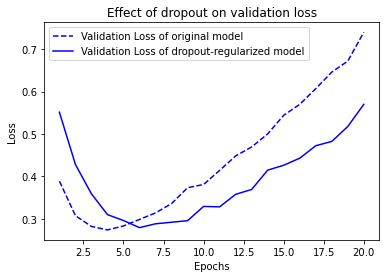

In [60]:
plt.plot(range(1, 21), history_original.history['val_loss'], 'b--', label='Validation Loss of original model')
plt.plot(range(1, 21), history_dropout.history['val_loss'], 'b-', label='Validation Loss of dropout-regularized model')
plt.title('Effect of dropout on validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()